Task: Medical Image Segmentation is an important problem in healthcare domain. Polyp recognition
and segmentation is one field which helps doctors identify polyps from colonoscope images.
CVC-Clinic database consists of frames extracted from colonoscopy videos. The dataset contains
several examples of polyp frames & corresponding ground truth for them.
The Ground Truth image consists of a mask corresponding to the region covered by the polyp in
the image. The data is available in both .png and .tiff format here: https://polyp.grandchallenge.org/CVCClinicDB/
Consider this task as a minor research project in which you should research the existing models
used (https://paperswithcode.com/dataset/cvc-clinicdb ) to identify polyps from these images.
Report on the key findings and the evaluation metrics used for this problem. Variants of the
Unet architecture are often used to solve this problem. Implement either Unet or any of its
variants (Unet++, ResUnet etc.) to segment the polyp images. This may be a computation
intensive task (requiring GPUs). In case you do not have access to GPUs simply reduce your
training data size to train your model. Report your results, compare and contrast these results
with at least 2 of the other research paper results

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile as tiff
import os

In [18]:
# Define transformations for images and masks separately
image_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

mask_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# Define dataset class
class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
        self.mask_list = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        try:
            img_array = tiff.imread(img_path)
            mask_array = tiff.imread(mask_path)
        except Exception as e:
            print(f"Error loading file: {e}")
            return None

        image = Image.fromarray(img_array).convert("RGB")
        mask = Image.fromarray(mask_array).convert("L")

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        mask = (mask > 0.5).float()  # Convert mask to binary
        return image, mask

# Define Double Convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Define UNet architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.conv_down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv_down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv_down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv_down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with dropout
        self.conv_bottleneck = DoubleConv(512, 1024, dropout=0.3)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, bias=False)
        self.conv_up4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, bias=False)
        self.conv_up3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, bias=False)
        self.conv_up2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, bias=False)
        self.conv_up1 = DoubleConv(128, 64)

        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.conv_down1(x)
        p1 = self.pool1(c1)
        c2 = self.conv_down2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv_down3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv_down4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        bottleneck = self.conv_bottleneck(p4)

        # Decoder
        u4 = self.up4(bottleneck)
        merge4 = torch.cat([u4, c4], dim=1)
        c5 = self.conv_up4(merge4)
        u3 = self.up3(c5)
        merge3 = torch.cat([u3, c3], dim=1)
        c6 = self.conv_up3(merge3)
        u2 = self.up2(c6)
        merge2 = torch.cat([u2, c2], dim=1)
        c7 = self.conv_up2(merge2)
        u1 = self.up1(c7)
        merge1 = torch.cat([u1, c1], dim=1)
        c8 = self.conv_up1(merge1)

        out = self.conv_last(c8)
        return out

# Define training function with learning rate scheduler
def train_model(model, train_loader, val_loader, num_epochs=10, accumulation_steps=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images, val_masks = val_images.to(device), val_masks.to(device)
                val_outputs = model(val_images)
                loss_val = criterion(val_outputs, val_masks)
                val_loss += loss_val.item() * val_images.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model

# Create datasets and dataloaders
train_dataset = PolypDataset(
    "/content/drive/My Drive/Projects in AI and ML/hw5/CVC-ClinicDB/Original",
    "/content/drive/My Drive/Projects in AI and ML/hw5/CVC-ClinicDB/Ground Truth",
    transform_img=image_transform,
    transform_mask=mask_transform
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

# Initialize and train the model
model = UNet(in_channels=3, out_channels=1)
trained_model = train_model(model, train_loader, val_loader, num_epochs=10)

# Define function to compute metrics
def compute_metrics(preds, targets, threshold=0.5):
    preds_bin = (preds.sigmoid() > threshold).float()
    targets_bin = (targets > 0.5).float()

    preds_flat = preds_bin.view(preds_bin.size(0), -1)
    targets_flat = targets_bin.view(targets_bin.size(0), -1)

    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = (preds_flat + targets_flat).sum(dim=1) - intersection

    dice = (2.0 * intersection) / (preds_flat.sum(dim=1) + targets_flat.sum(dim=1) + 1e-8)
    iou = intersection / (union + 1e-8)

    precision = intersection / (preds_flat.sum(dim=1) + 1e-8)
    recall = intersection / (targets_flat.sum(dim=1) + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return {
        'dice': dice.mean().item(),
        'iou': iou.mean().item(),
        'precision': precision.mean().item(),
        'recall': recall.mean().item(),
        'f1': f1.mean().item()
    }


Epoch [1/10], Loss: 0.3596, Val Loss: 0.2895
Epoch [2/10], Loss: 0.2651, Val Loss: 0.2775
Epoch [3/10], Loss: 0.2341, Val Loss: 0.2403
Epoch [4/10], Loss: 0.2230, Val Loss: 0.2352
Epoch [5/10], Loss: 0.2045, Val Loss: 0.2065
Epoch [6/10], Loss: 0.1887, Val Loss: 0.1930
Epoch [7/10], Loss: 0.1803, Val Loss: 0.1850
Epoch [8/10], Loss: 0.1744, Val Loss: 0.1689
Epoch [9/10], Loss: 0.1606, Val Loss: 0.1709
Epoch [10/10], Loss: 0.1561, Val Loss: 0.1810


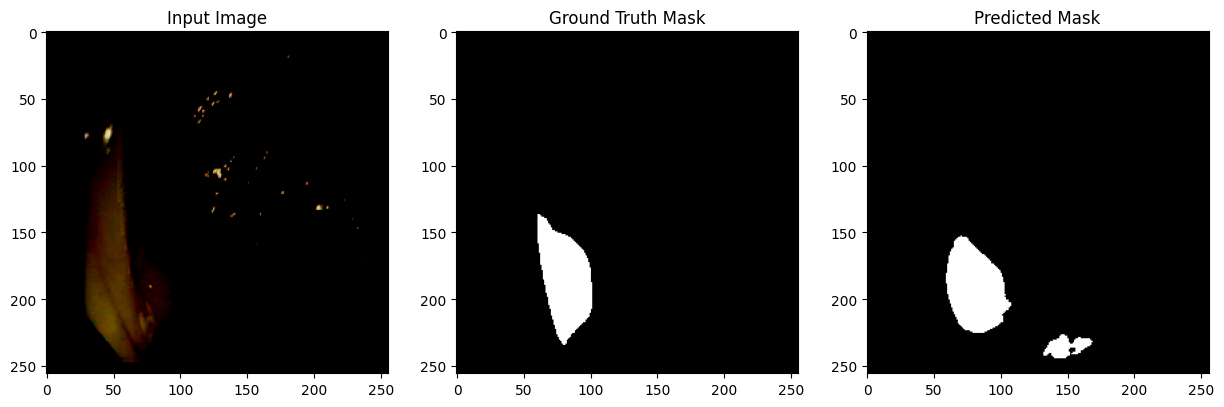

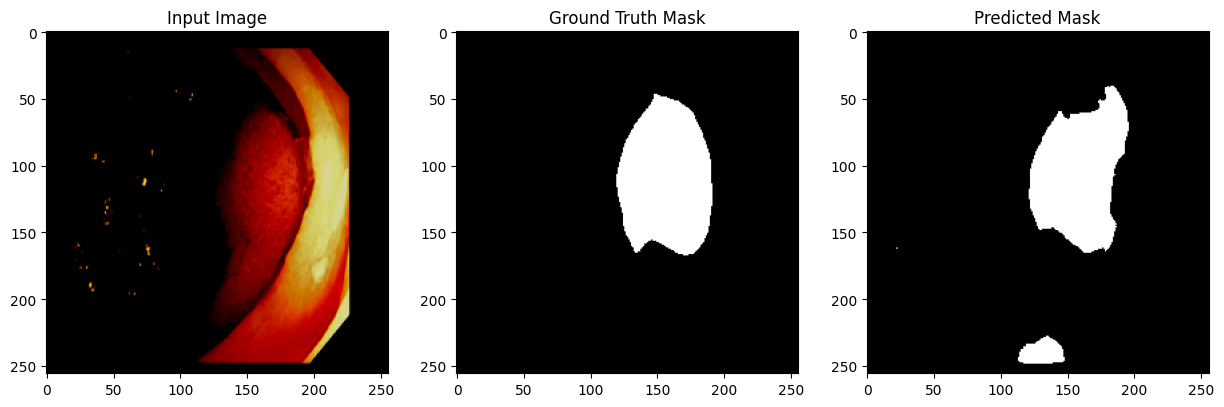

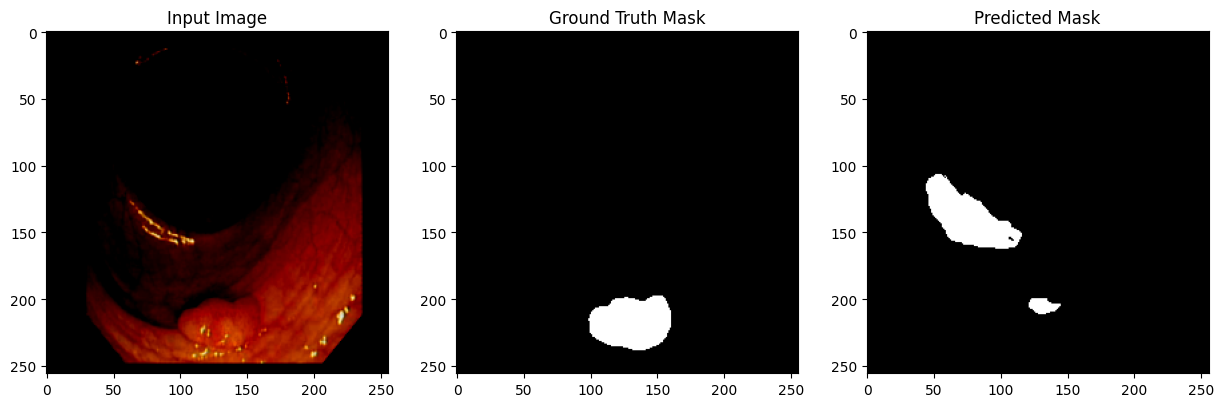

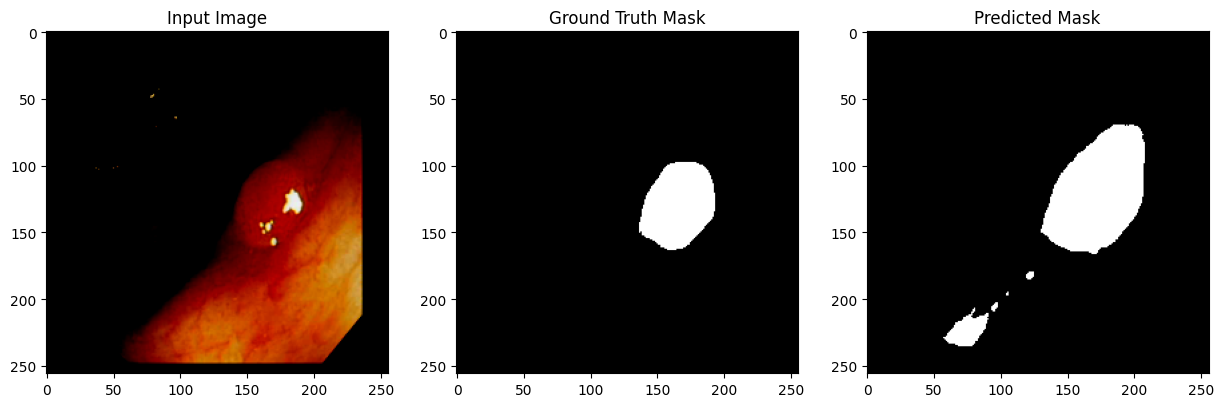

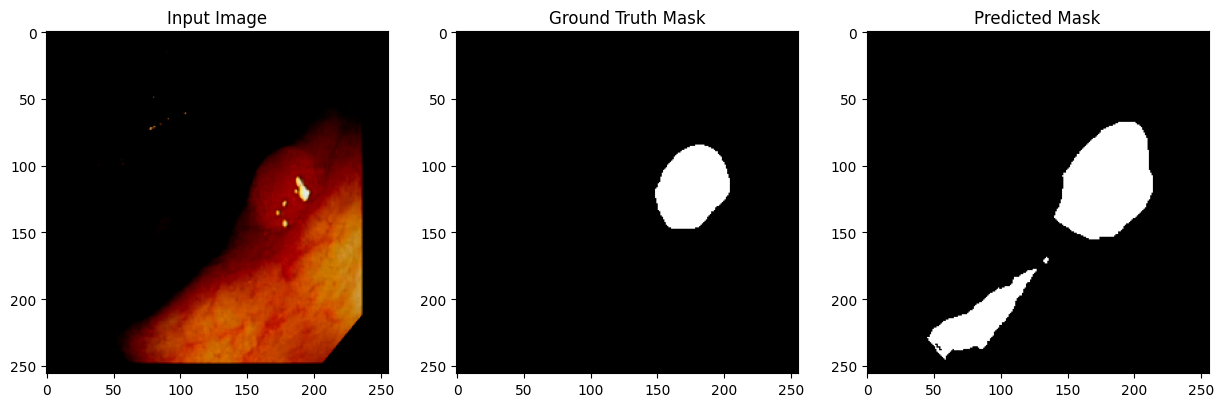

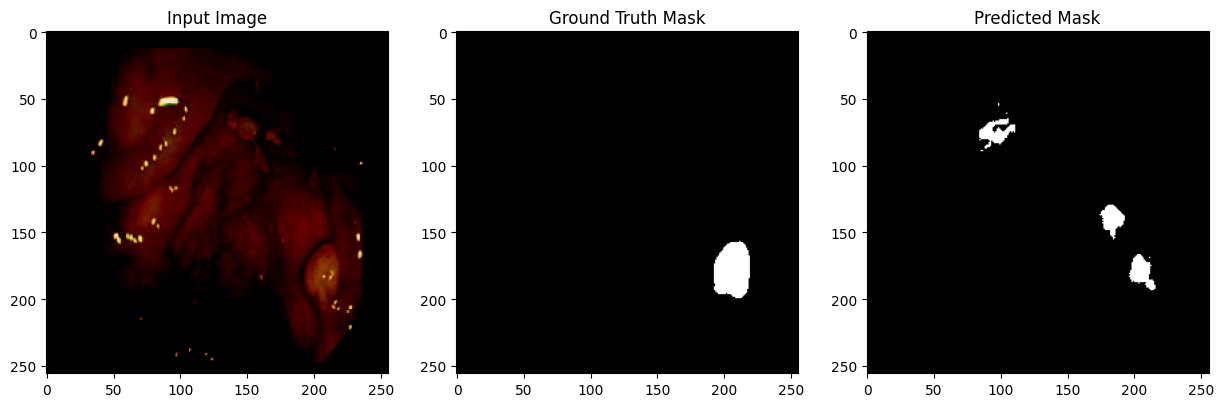

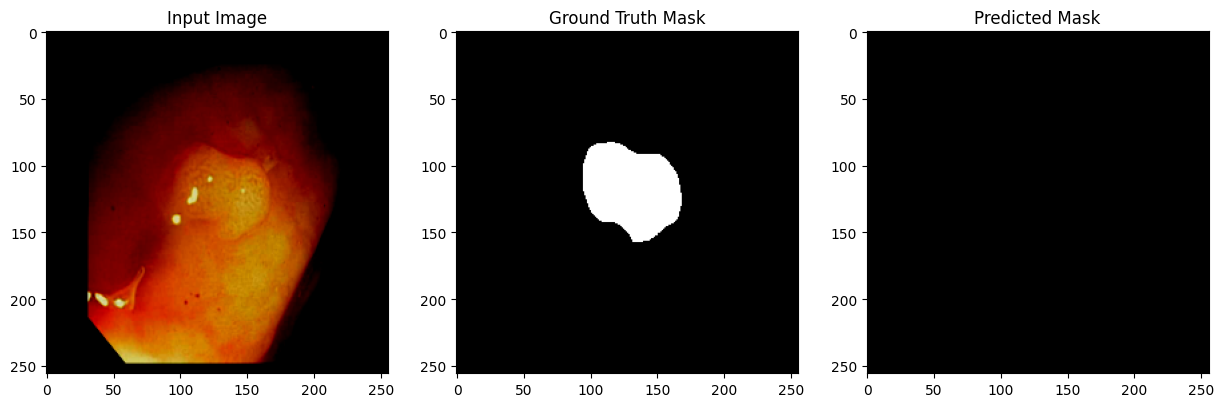

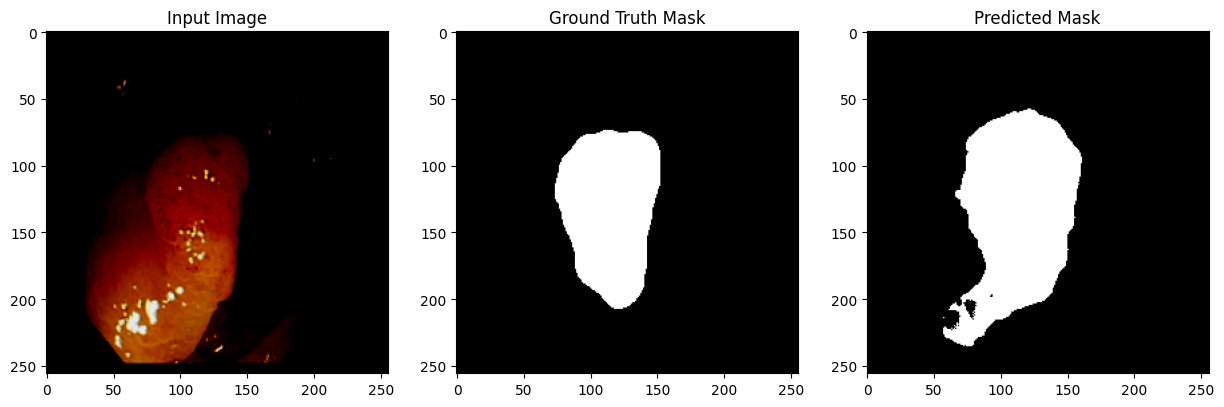

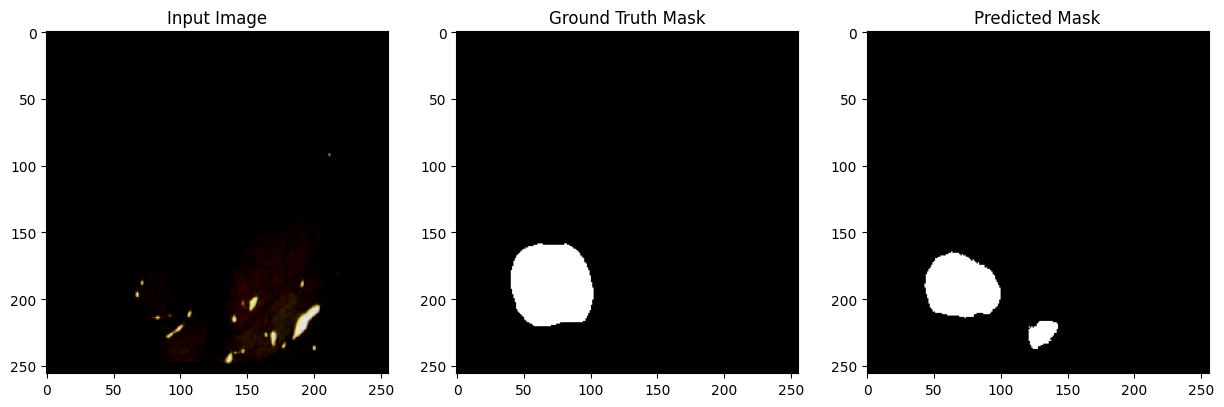

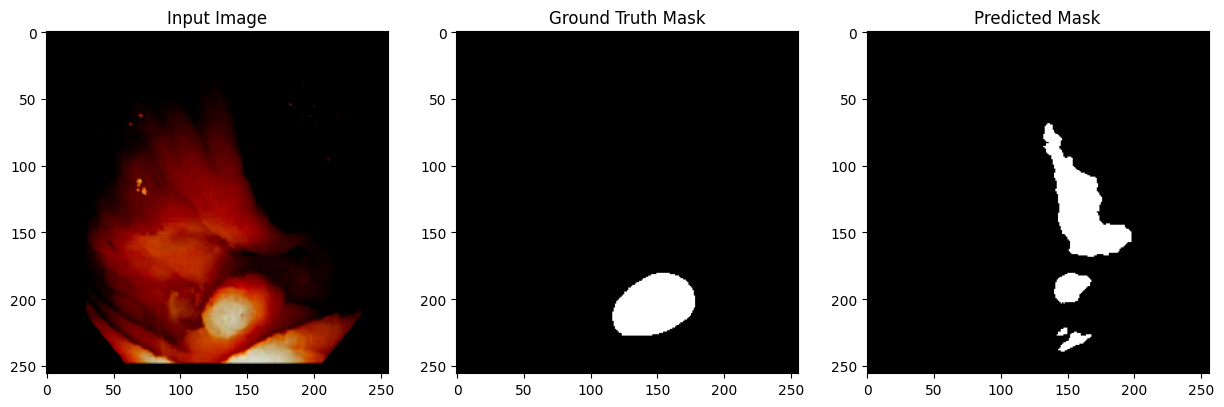

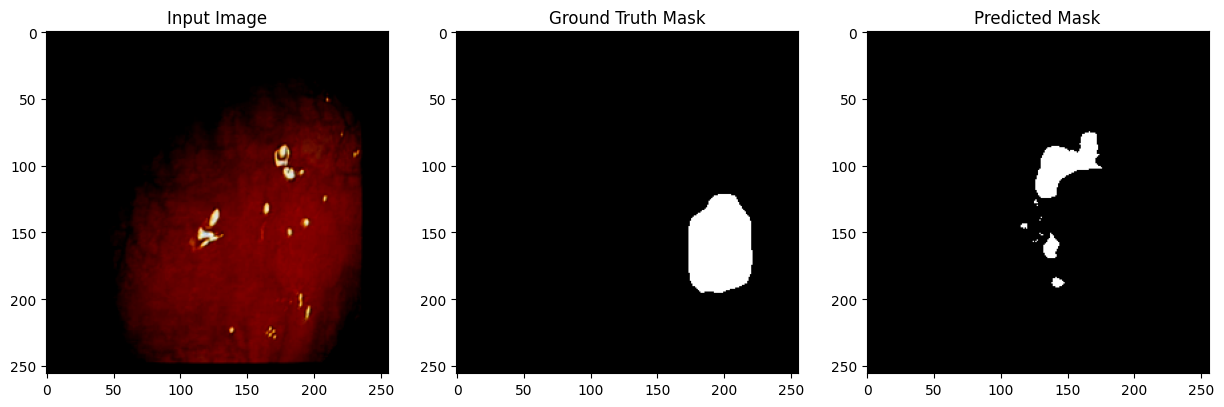

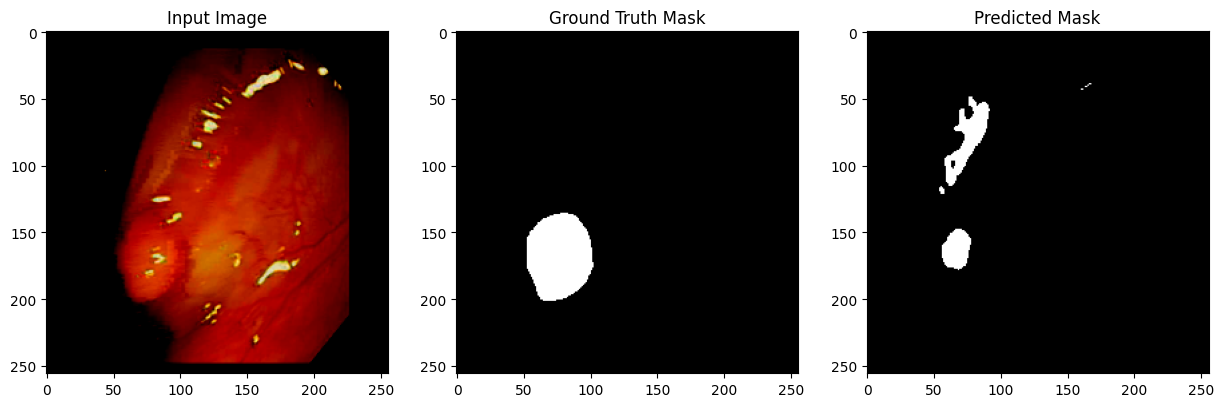

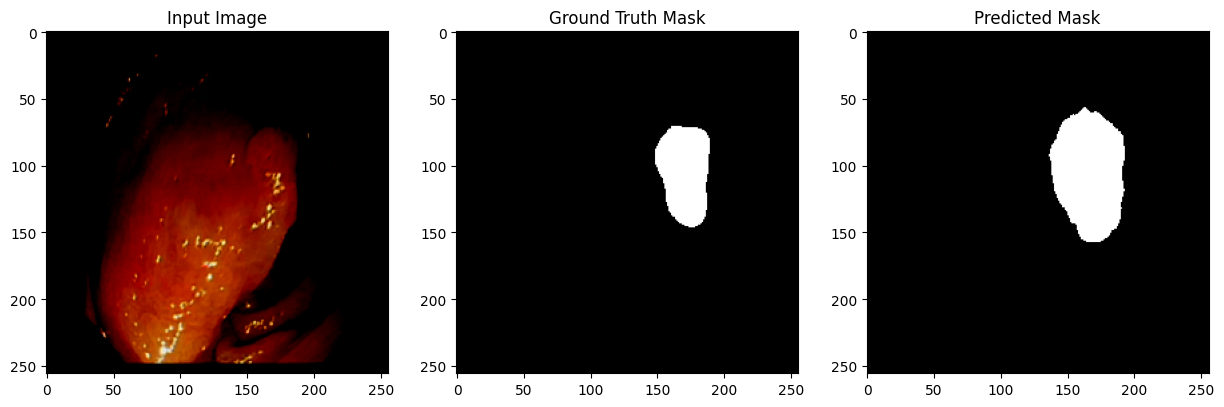

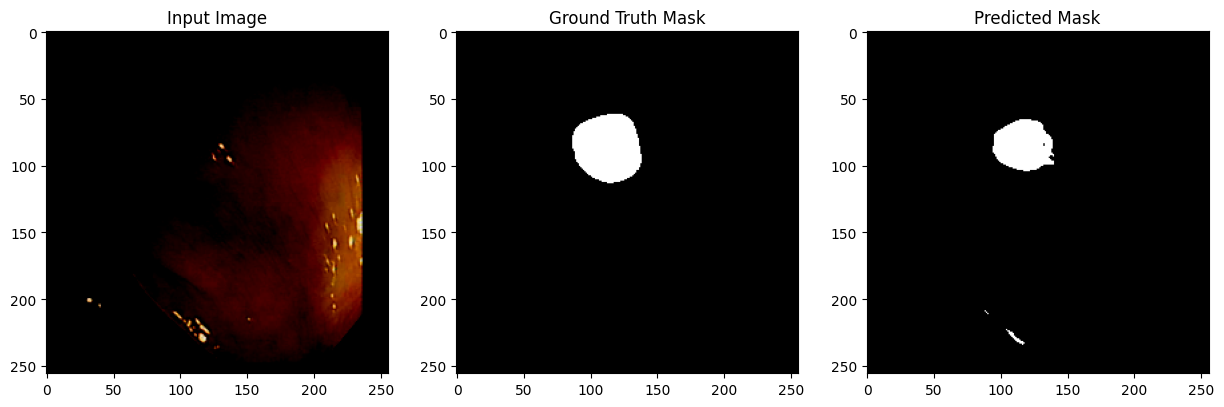

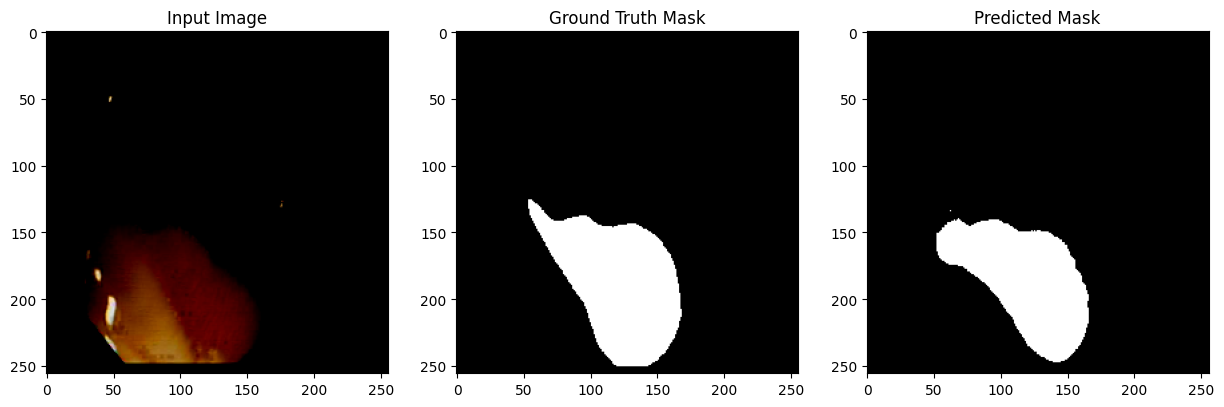

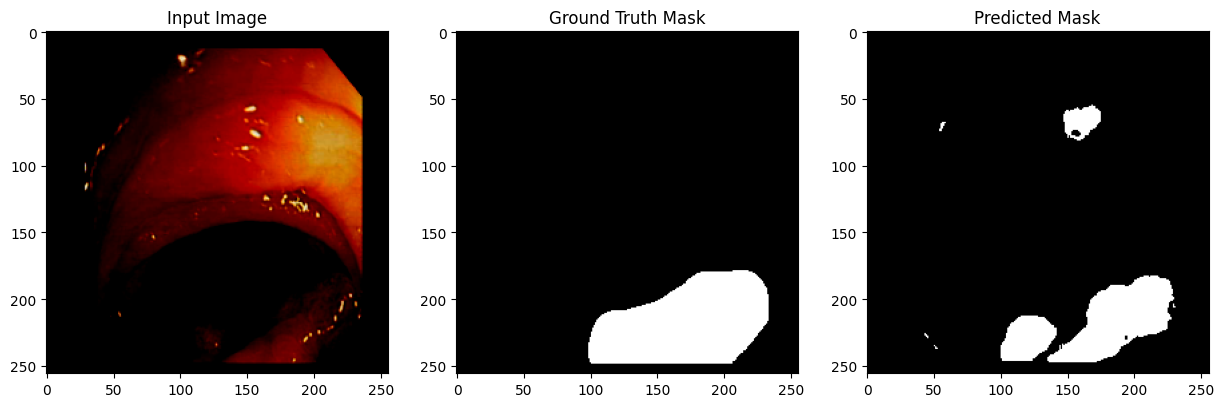

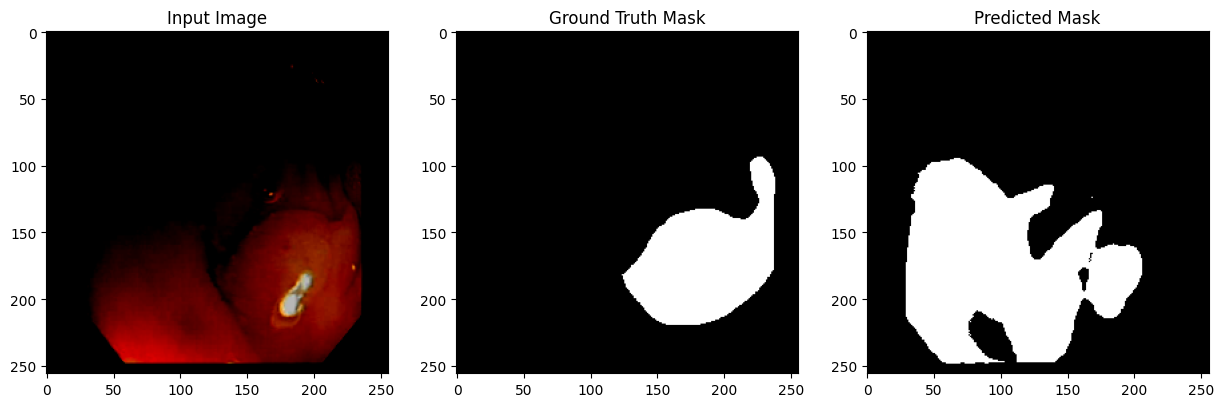

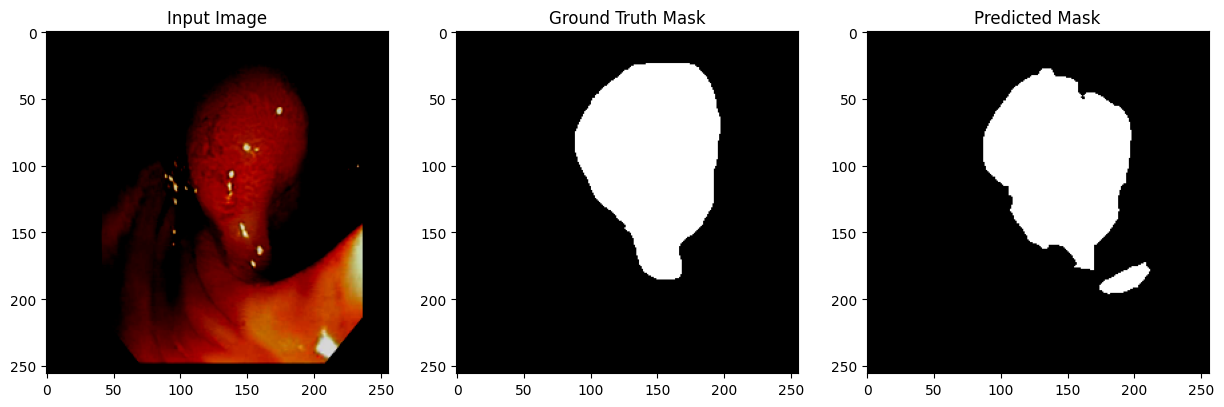

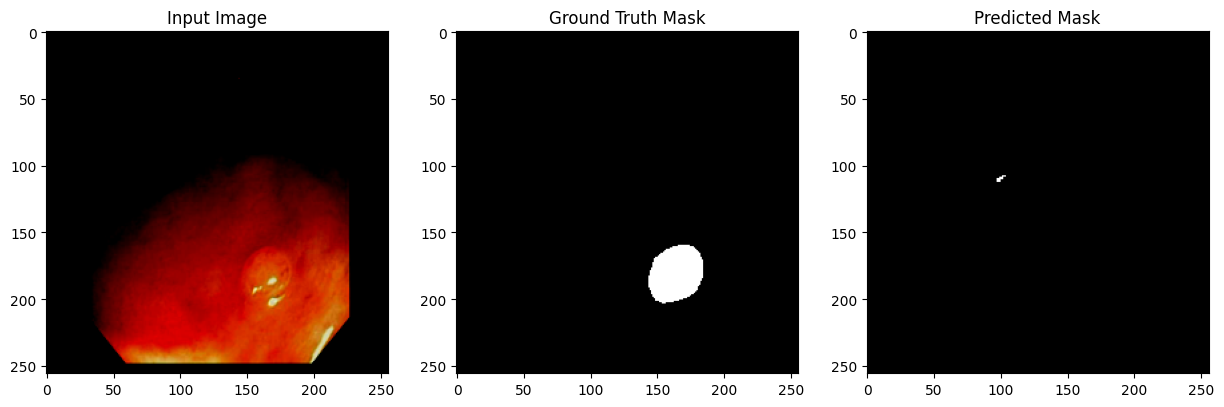

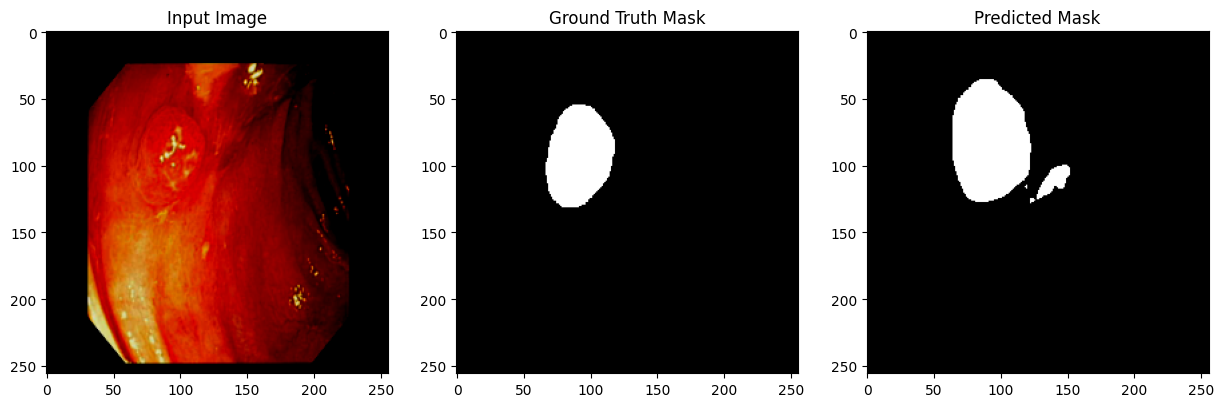

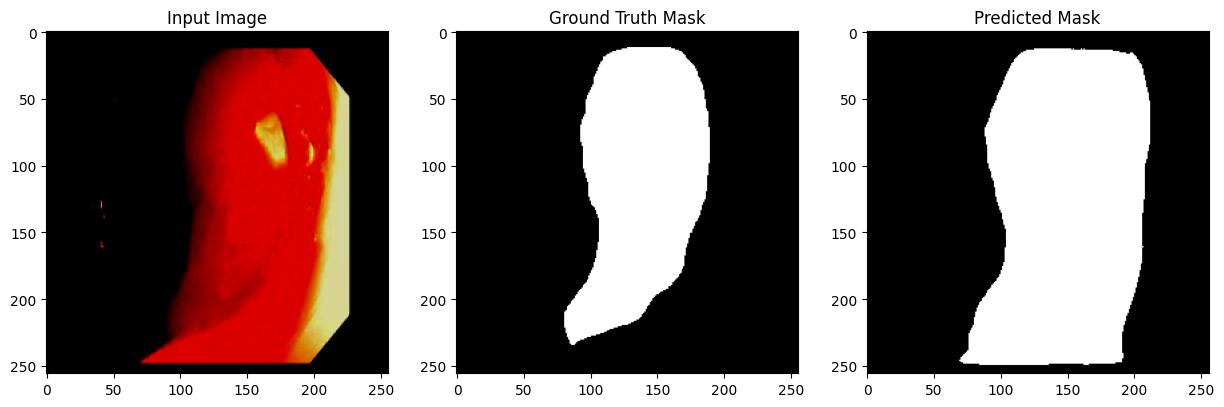

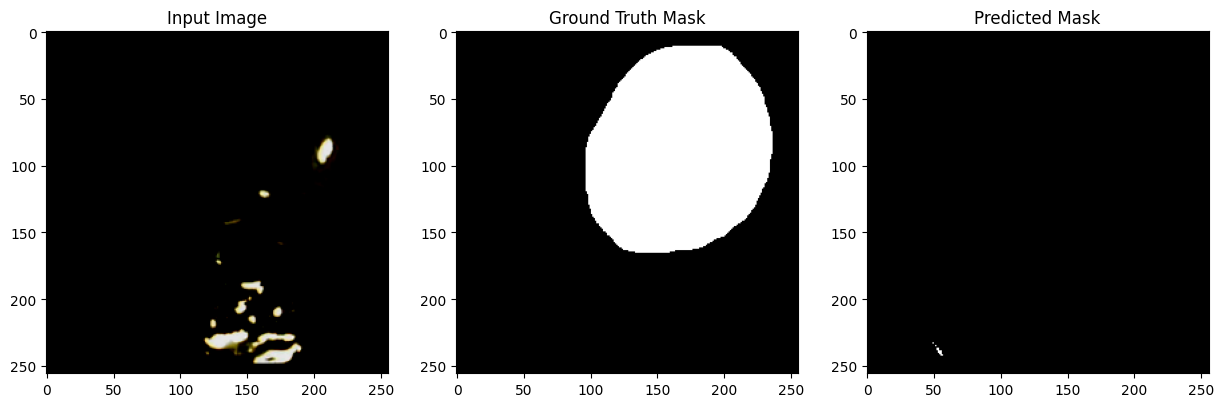

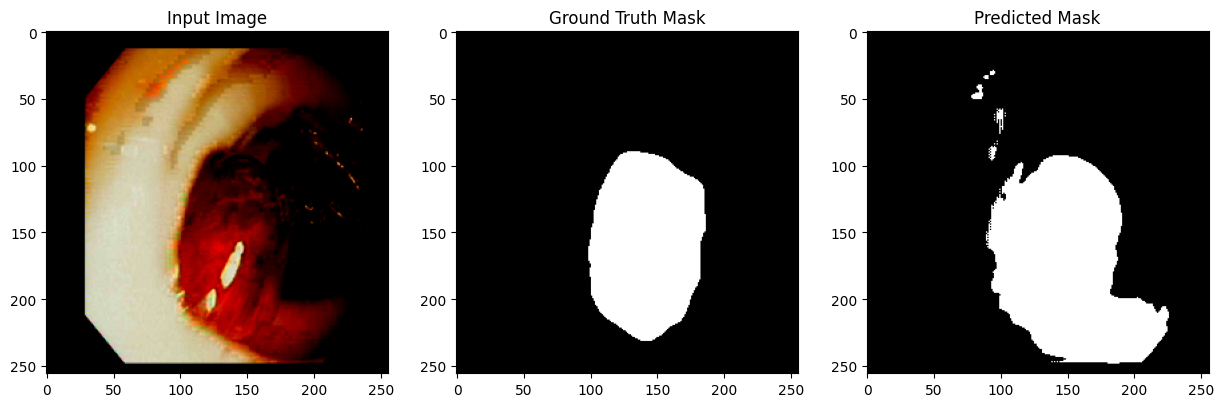

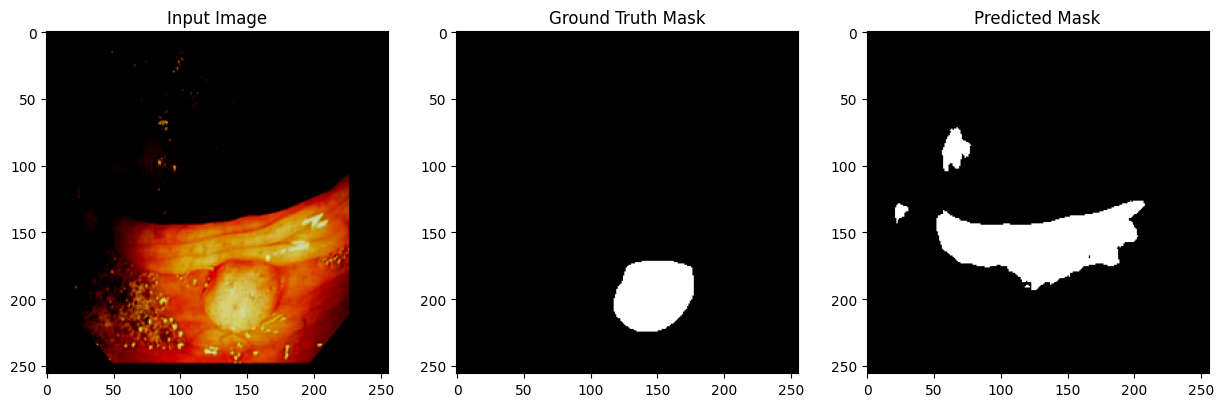

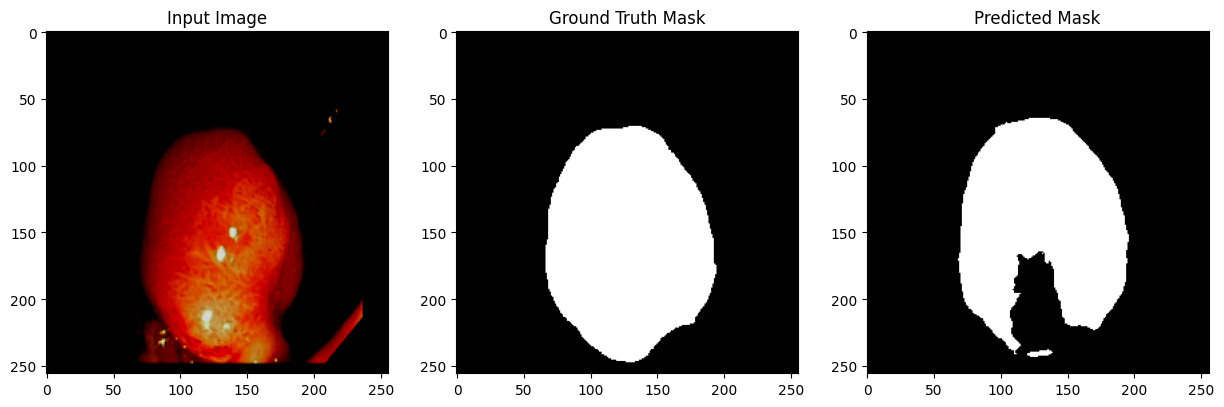

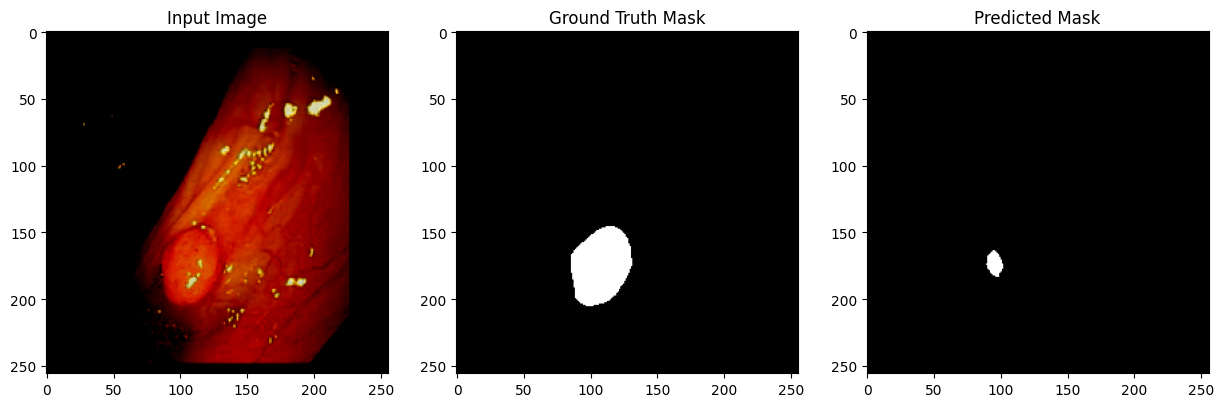

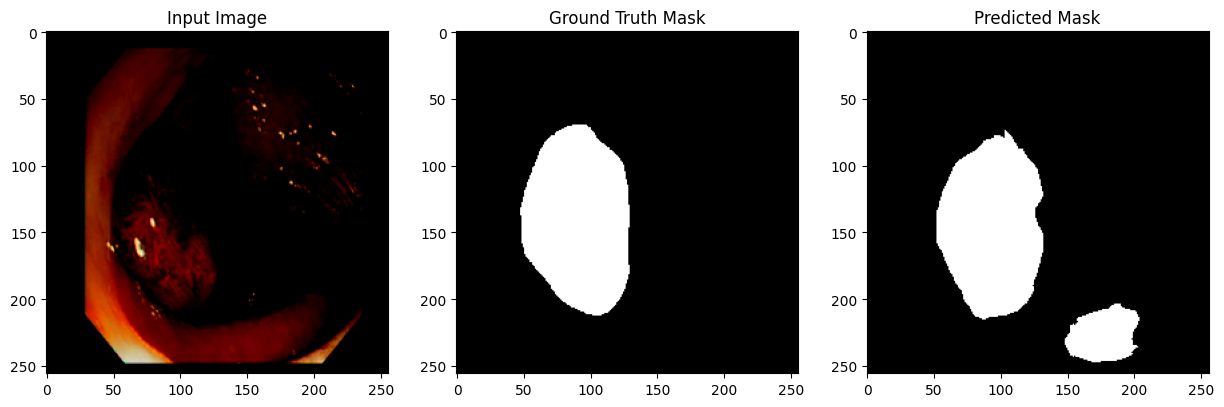

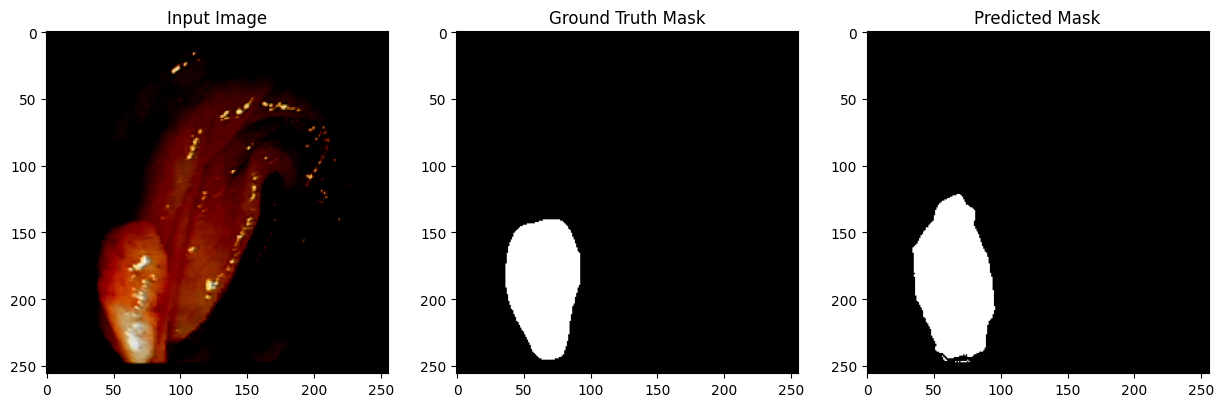

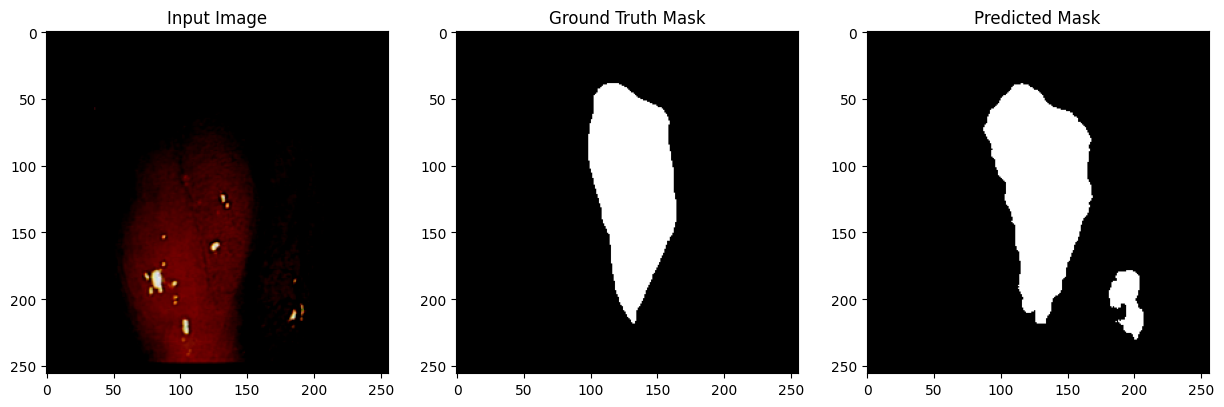

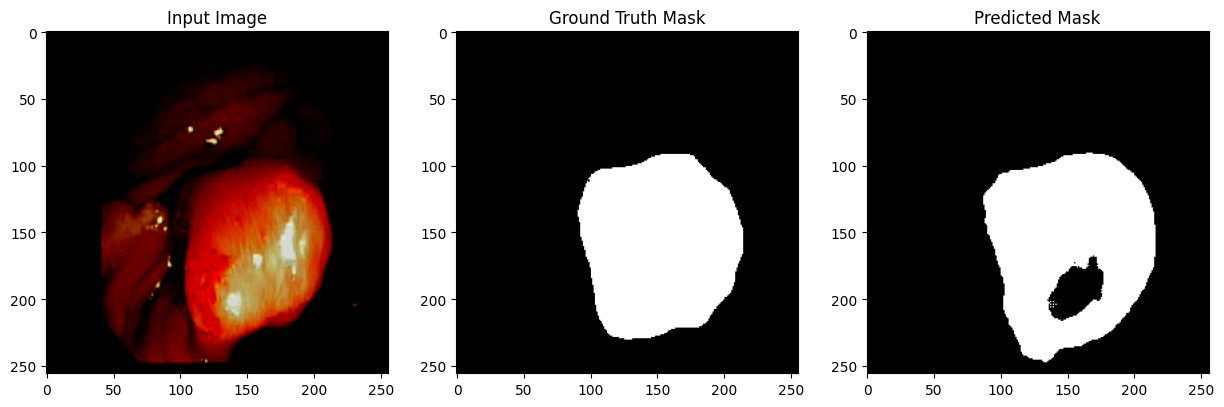

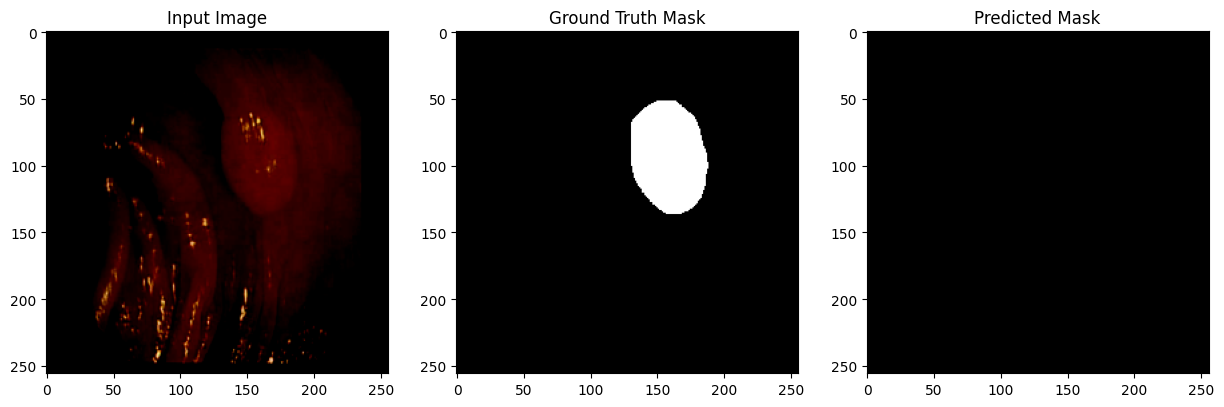

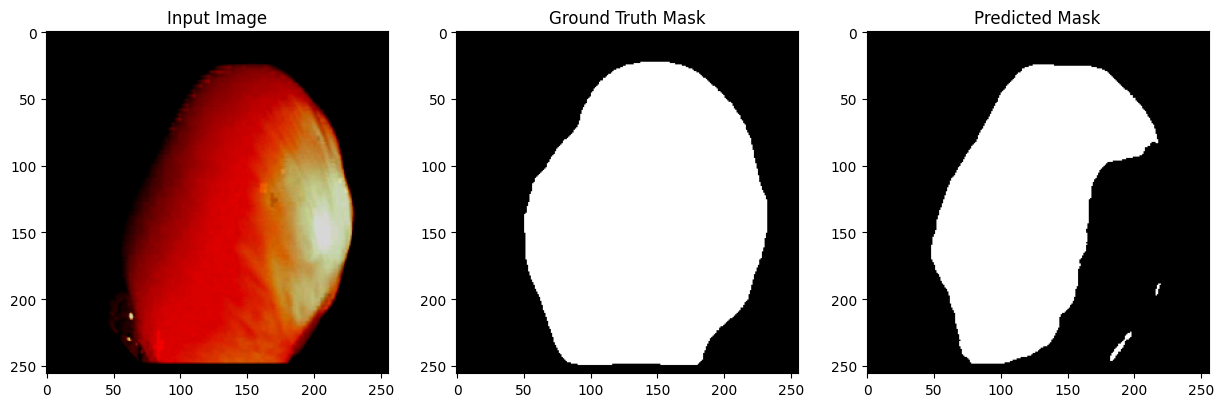

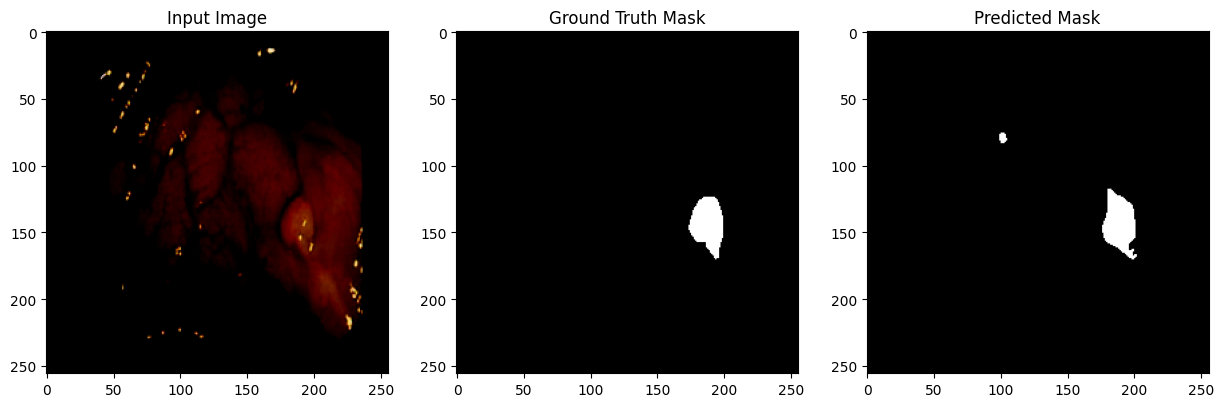

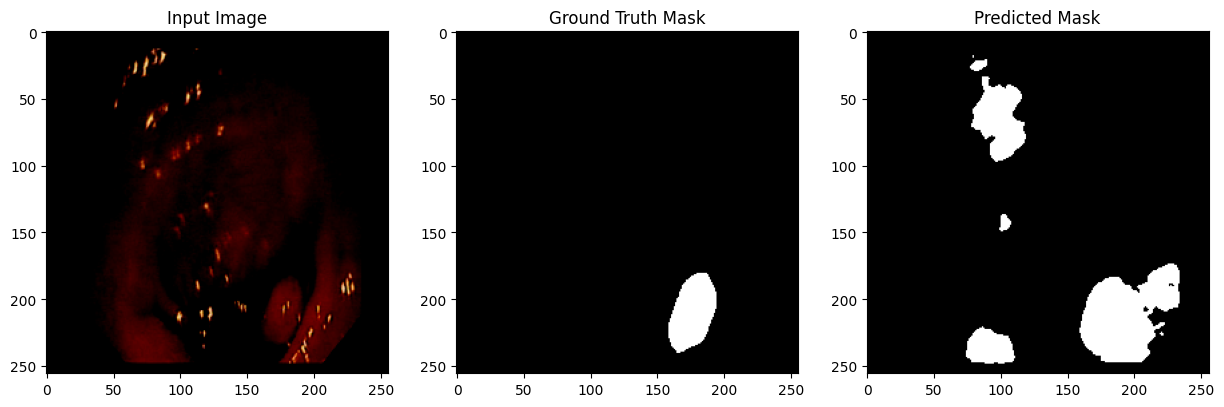

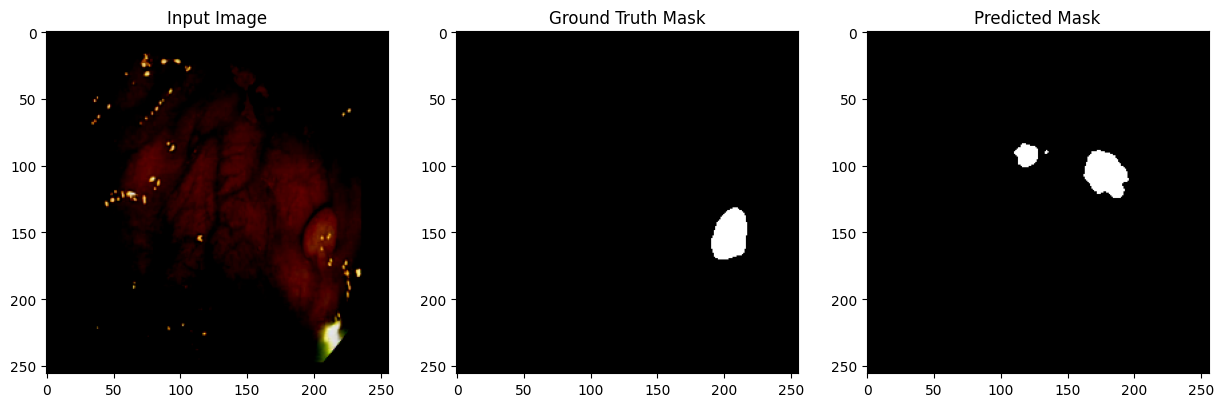

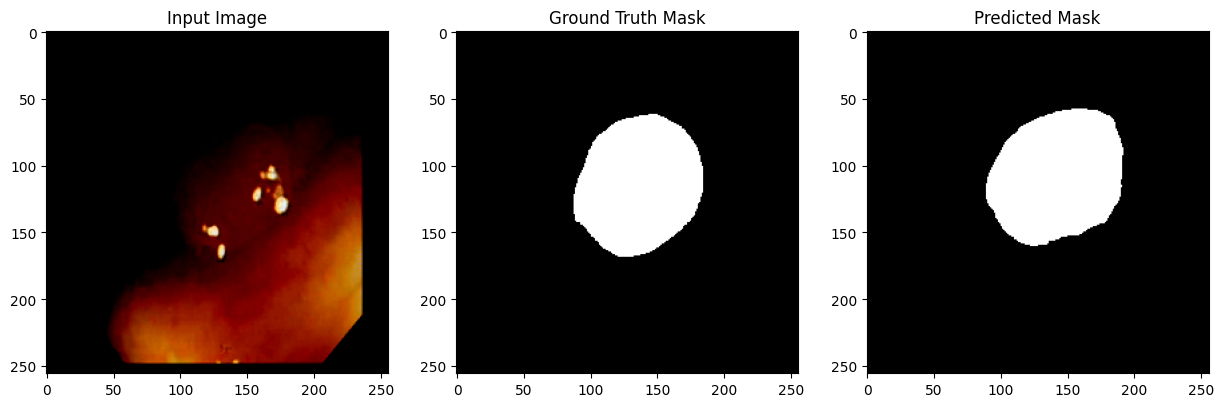

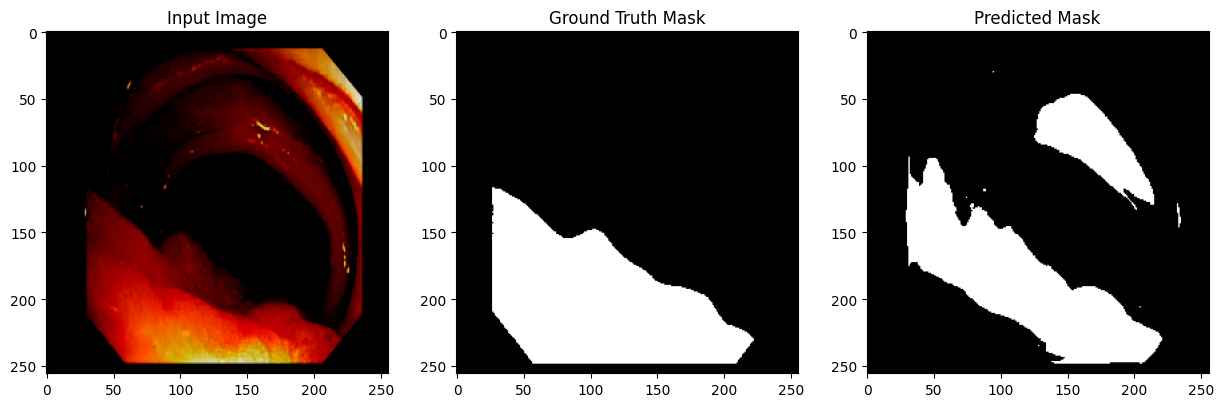

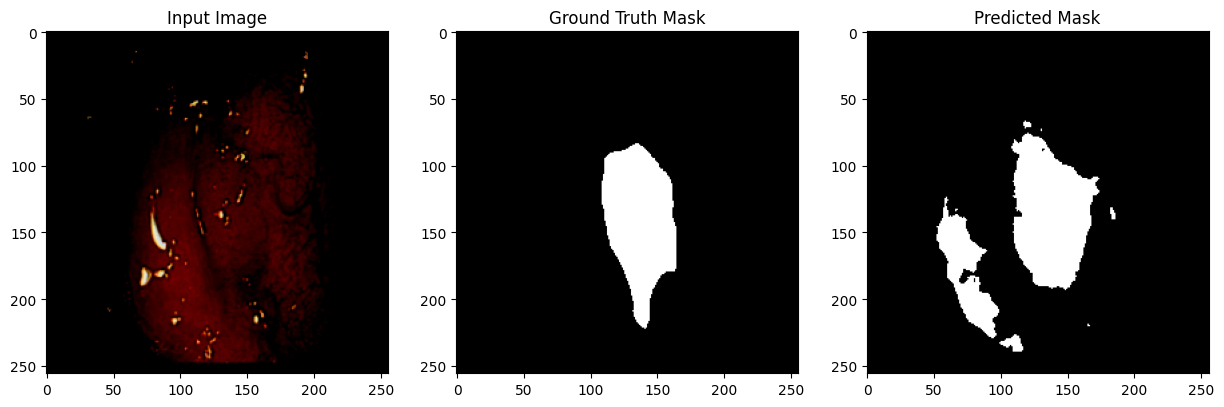

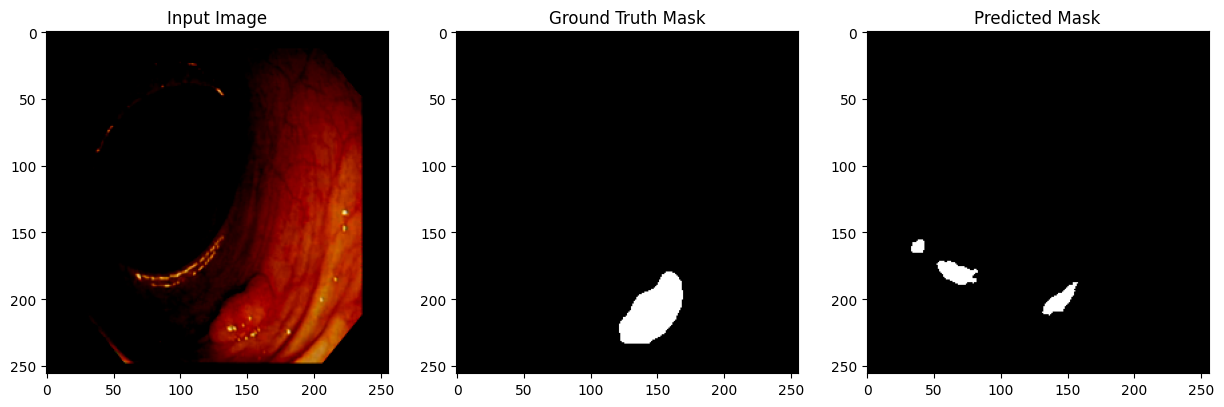

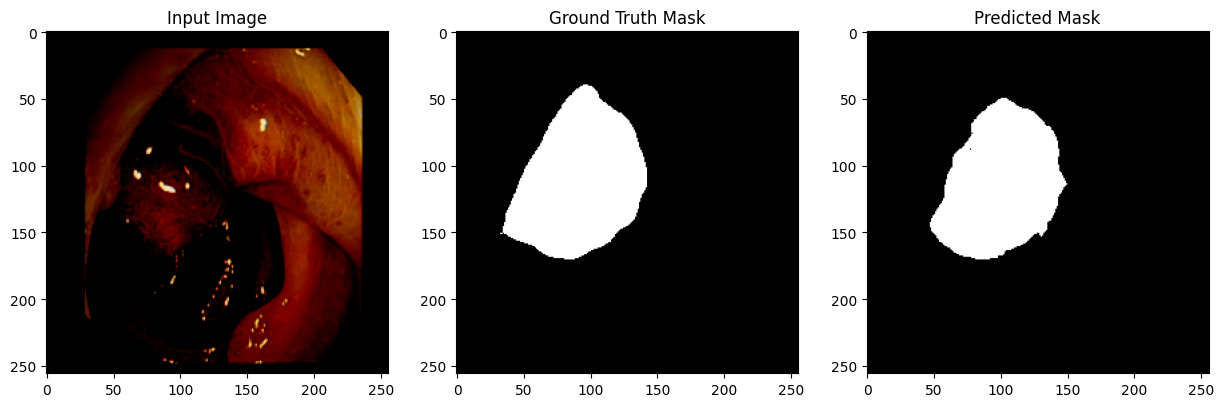

In [19]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    with torch.no_grad():
        for i, (images, masks) in enumerate(data_loader):
            if i >= num_samples:
                break
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            for j in range(images.size(0)):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(images[j].cpu().permute(1, 2, 0))
                axes[0].set_title("Input Image")
                axes[1].imshow(masks[j].cpu().squeeze(), cmap='gray')
                axes[1].set_title("Ground Truth Mask")
                axes[2].imshow(preds[j].cpu().squeeze(), cmap='gray')
                axes[2].set_title("Predicted Mask")
                plt.show()

visualize_predictions(trained_model, val_loader)


In [23]:
# prompt: can you write code to evaluate the model above

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.eval()
trained_model.to(device)

metrics_list = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = trained_model(images)
        metrics = compute_metrics(outputs, masks)
        metrics_list.append(metrics)

average_metrics = {}
for metric_name in metrics_list[0]:
    average_metrics[metric_name] = sum([metrics[metric_name] for metrics in metrics_list]) / len(metrics_list)

print("Average Evaluation Metrics on Validation Set:")
for metric_name, metric_value in average_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")


Average Evaluation Metrics on Validation Set:
dice: 0.5277
iou: 0.4136
precision: 0.5428
recall: 0.6160
f1: 0.5277


The code addresses the problem of polyp segmentation in colonoscopy images. The goal is to automatically identify and delineate the regions in images that correspond to polyps. This is a crucial task in medical image analysis, as it can help doctors detect polyps early, leading to better patient outcomes.  

The code implements a U-Net model, a convolutional neural network architecture commonly used for image segmentation tasks. It utilizes an encoder-decoder structure with skip connections to learn both global and local context from the input images.  

The code trains a U-Net model to perform polyp segmentation on the CVC-ClinicDB dataset. The `visualize_predictions` function shows how the trained model is performing visually on the validation set. The `average_metrics` computation shows the quantitative metrics (Dice, IoU, Precision, Recall, F1) calculated on the validation set.


The U-Net model is able to achieve reasonable performance on the polyp segmentation task, as shown by the calculated evaluation metrics, but it isn't the best with a dice score of 0.52. This is not as good as results from other research. For example, DUCK-Net has a dice of 0.97 and IoU of 0.93. My model is far off from these. However, U-Net++ has a dice of 0.79, which is closer to my results, but still somewhat far off.


